In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from multiprocessing import Pool
import warnings
warnings.filterwarnings('ignore')

PROJECT_PATH = Path("/home/wak/toprak-lab/aml_drug_synergy")

In [2]:
dic50_df = pd.read_csv(PROJECT_PATH / 'dump/sigmoid_synergy_estimations/bliss_v_observed_8_delta_ic50.csv')
print('Total drug pairs:', dic50_df[dic50_df['valid'] == 'VALID'].groupby(['drugA','drugB'])['dIC50'].mean().shape[0])
print('total number of drug combinations:', sum(dic50_df['valid'] == 'VALID'))
print('Total number of viability measurements:',sum(dic50_df['valid'] == 'VALID')*64)
dic50_df = dic50_df[dic50_df['valid']=='VALID']
dic50_df

Total drug pairs: 119
total number of drug combinations: 3167
Total number of viability measurements: 202688


,cell_line,drugA,drugB,drugB_conc,dIC50,valid
232,FKH1,6TG,6TG,0.000000,-0.067187,VALID
233,FKH1,6TG,6TG,2.980232,-0.652152,VALID
234,FKH1,6TG,6TG,4.768372,-0.668315,VALID
235,FKH1,6TG,6TG,7.629395,-0.745679,VALID
236,FKH1,6TG,6TG,12.207030,-0.278836,VALID
...,...,...,...,...,...,...
5633,Kasumi1,VP16,VP16,0.004100,-0.156507,VALID
5634,Kasumi1,VP16,VP16,0.010200,-0.181796,VALID
5635,Kasumi1,VP16,VP16,0.025600,-0.559810,VALID
5636,Kasumi1,VP16,VP16,0.064000,-0.244749,VALID


In [3]:
def classify_max(x):
    if np.median(x[1:])>0:
        return np.max(x)
    elif np.median(x[1:])<0:
        return np.min(x)
    else:
        return np.nanmedian(x[1:])
# first classify as synergistic, antagonistic, independence, than select max
df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(classify_max).to_frame().reset_index()
df_max = df_max[ ~(df_max['drugA']==df_max['drugB']) ]

#### Generate dIC50 shift heatmaps per cell line

In [4]:
for cell_line in dic50_df['cell_line'].unique():
    df = df_max[df_max['cell_line']==cell_line]
    dfp = df.pivot(index=['drugA'], columns=['drugB'], values=['dIC50']).droplevel(level=0,axis=1)
    sns.set_theme(style="white")
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(-dfp, cmap=cmap, vmax=5, center=0, vmin=-5,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                xticklabels=dfp.columns, yticklabels=dfp.index)
    ax.tick_params(axis='x',labelsize=10)
    ax.set_title(cell_line)
    f.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/bliss_v_observed_delta_ic50_heatmaps/{cell_line}_dic50_heatmap.png', dpi=300)
    plt.close(f)

#### Generate dIC50 heatmaps combined single figure

In [5]:
cell_line_custom = ['FKH1','HL60','TF1','IDH2','Kasumi1','K562']

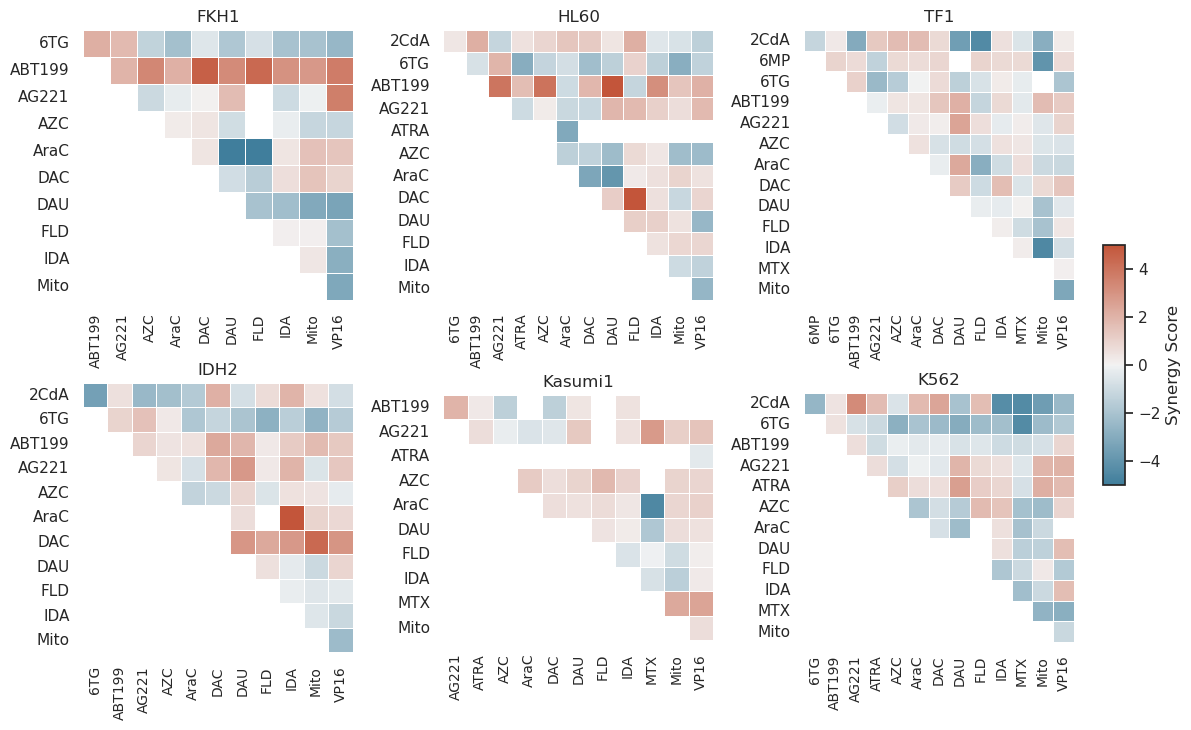

In [6]:
# Option 1: Get max
# df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(min).to_frame().reset_index()
# Option 2: Get mean of max 2
# df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(lambda x: np.mean(np.sort(np.array(x)[0:2]))).to_frame().reset_index()
# Option 3: first classify as synergistic, antagonistic, independence, than select max
df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(classify_max).to_frame().reset_index()
df_max = df_max[ ~(df_max['drugA']==df_max['drugB']) ]

sns.set_theme(style="white")
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Set up the matplotlib figure
f, axes = plt.subplots(2,3,figsize=(11, 8))

for ploti, cell_line in enumerate(cell_line_custom):
    ax = axes.flat[ploti]
    df = df_max[df_max['cell_line']==cell_line]
    dfp = df.pivot(index=['drugA'], columns=['drugB'], values=['dIC50']).droplevel(level=0,axis=1)
    # Draw the heatmap with the mask and correct aspect ratio
    hax = sns.heatmap(-dfp, ax=ax, cmap=cmap, vmax=5, center=0, vmin=-5,
                square=True, linewidths=.5, 
                xticklabels=dfp.columns, yticklabels=dfp.index,
                cbar=False, cbar_kws={"shrink": .5, "location":"right"})
    #ax.set_xticklabels(dfp.columns)
    ax.tick_params(axis='x',labelsize=10)
    ax.set_title(cell_line)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # if not(ploti in [0,3]):
    #     ax.set_yticklabels([])
    # if ploti in [0,1,2]:
    #     ax.set_xticklabels([])
cbar_ax = f.add_axes([1.01, 0.35, 0.02, 0.3])
f.colorbar(hax.get_children()[0], cax=cbar_ax, label='Synergy Score')
f.tight_layout()
f.subplots_adjust(hspace=0.0)
f.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/bliss_v_observed_delta_ic50_heatmaps/dic50_heatmap_by_drug_pair.png',
          dpi=600, bbox_inches="tight")

In [7]:
df_max_na = df_max[~pd.isna(df_max['dIC50'])]
print('Mean dIC50:', df_max_na.loc[:,'dIC50'].mean())
print('Std dIC50:', df_max_na.loc[:,'dIC50'].std())
print('d > 1:', sum(df_max_na.loc[:,'dIC50']>=1))
print('Synergy < -1:', sum(df_max_na.loc[:,'dIC50']<=-1))
print('ABT199 or AG221:', sum((
                              (df_max_na.loc[:,'drugA'].apply(lambda x: x in ['AG221','ABT199'])
                              | df_max_na.loc[:,'drugB'].apply(lambda x: x in ['AG221','ABT199']))
                              & (df_max_na.loc[:,'dIC50']>-1))))
df_max[~pd.isna(df_max['dIC50'])]

Mean dIC50: 0.07648924397390469
Std dIC50: 1.8254731326525404
d > 1: 118
Synergy < -1: 97
ABT199 or AG221: 74


,cell_line,drugA,drugB,dIC50
1,FKH1,6TG,ABT199,-2.124312
2,FKH1,6TG,AG221,-1.762509
3,FKH1,6TG,AZC,1.343553
4,FKH1,6TG,AraC,2.160773
5,FKH1,6TG,DAC,0.516877
...,...,...,...,...
476,TF1,IDA,MTX,-0.169115
477,TF1,IDA,Mito,4.568548
478,TF1,IDA,VP16,0.849882
480,TF1,MTX,VP16,-0.090148


#### Generate dIC50 heatmaps combined and grouped by cell line

In [8]:
dfp = df_max.pivot(index=['drugA','drugB'],columns=['cell_line'])
# filter out drug pairs with less than two cell lines
dfp_filt = dfp[dfp.apply(lambda x: sum(~pd.isna(x))>0,axis=1)]
# filter out cell lines that does not have greater than 2 fold change in at least one cell line
dfp_filt = dfp_filt[dfp_filt.apply(lambda x: ((x>1).any() or (x<-1).any()),axis=1)]
# re-introduce flipped drug pairs for visual completeness
for i, r in dfp_filt.iterrows():
    dfp_filt.loc[(i[1],i[0]),:] = dfp_filt.loc[i,:]
dfp_filt.sort_index(inplace=True)
# remove level artifact
dfp_filt.columns = dfp_filt.columns.droplevel(0)
# custom sort cell lines
dfp_filt = dfp_filt.loc[:,cell_line_custom]
print(dfp_filt.shape)

(178, 6)


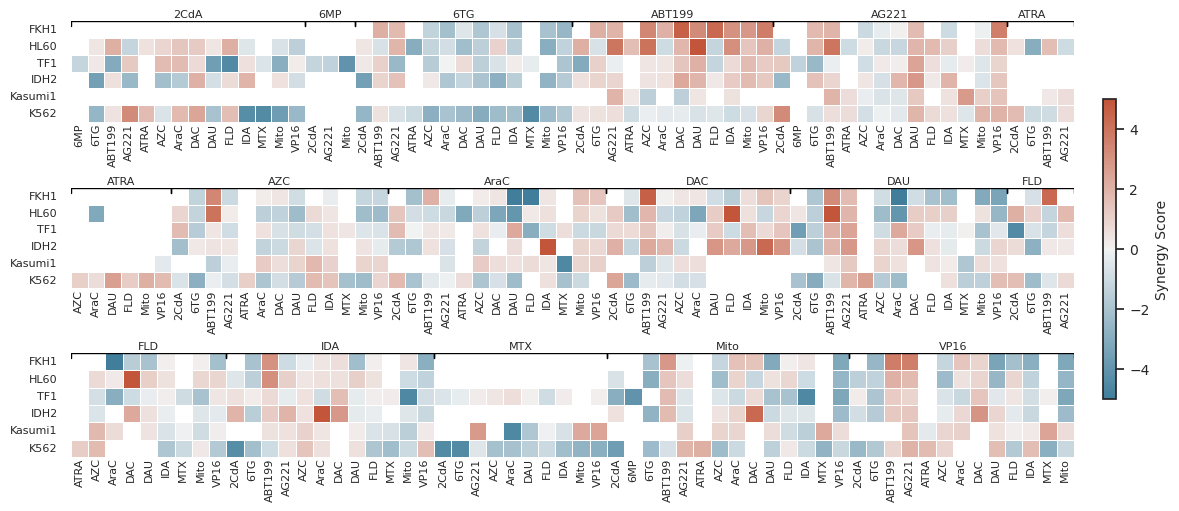

In [9]:
fig, axes = plt.subplots(3,1,figsize=(11,6))
for axi, r in enumerate([range(0,60), range(60,120), range(120,dfp_filt.shape[0])]):
    ax = axes[axi]
    hax = sns.heatmap(-dfp_filt.T.iloc[:,r], ax=ax, cmap=cmap, vmax=5, center=0, vmin=-5,
                    square=True, linewidths=.5, 
                    xticklabels=[f'{l[1]}' for l in dfp_filt.index[r]],
                    yticklabels=dfp_filt.columns,
                    cbar=False, cbar_kws={"shrink": .5, "location":"right"})
    ax.tick_params(labelsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), position=(0, 0.12))

    column_labels = [f'{l[0]}' for l in dfp_filt.index[r]]
   # Process the column labels to determine the start and end column for each group
    prev_label = column_labels[0]
    start_col = 0
    for i, label in enumerate(column_labels[1:], 1):
        if label != prev_label:
            # If label changes, then put the group label and bracket for the previous group
            end_col = i - 1
            center_col = (start_col + end_col + 1) / 2
            
            ax.annotate(prev_label, 
                        xy=(center_col, 0),
                        xycoords='data',
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='center',
                        fontsize=8)

            bracket_length = 0.3
            line = plt.Line2D([start_col, start_col, end_col+1, end_col+1],
                            [bracket_length, 0, 0, bracket_length],
                            color='black', lw=1)
            ax.add_line(line)
            
            # Start a new group
            start_col = i
            prev_label = label

    # Add label and bracket for the last group
    center_col = (start_col + i) / 2
    ax.annotate(prev_label, 
                xy=(center_col, 0),
                xycoords='data',
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='center',
                fontsize=8)

    bracket_length = 0.3
    line = plt.Line2D([start_col, start_col, i+1, i+1],
                    [bracket_length, 0, 0, bracket_length],
                    color='black', lw=1)
    ax.add_line(line)


fig.tight_layout()
cbar_ax = fig.add_axes([1.01, 0.25, 0.012, 0.5])
cbar = fig.colorbar(hax.get_children()[0], cax=cbar_ax)
cbar.set_label(label='Synergy Score', size=10)
cbar.ax.tick_params(labelsize=10)
fig.subplots_adjust(hspace=-0.2)
fig.savefig(PROJECT_PATH / f'figures/Figure 2. dIC50 heatmap by cell line 8-by-8.png',
            dpi=600, bbox_inches='tight')

In [67]:
df = -dfp_filt.T

In [68]:
series = df.median()
sorted_series = series.groupby(level=0, group_keys=False).apply(lambda x: x.sort_values(ascending=False))
sorted_series

drugA  drugB 
2CdA   DAC       1.672888
       AraC      1.535917
       FLD       1.167651
       ATRA      1.112249
       ABT199    0.501629
                   ...   
VP16   AZC      -0.457954
       IDA      -0.979028
       2CdA     -1.144296
       6TG      -1.761722
       Mito     -2.455456
Length: 178, dtype: float64

In [69]:
df[df>0]=np.nan

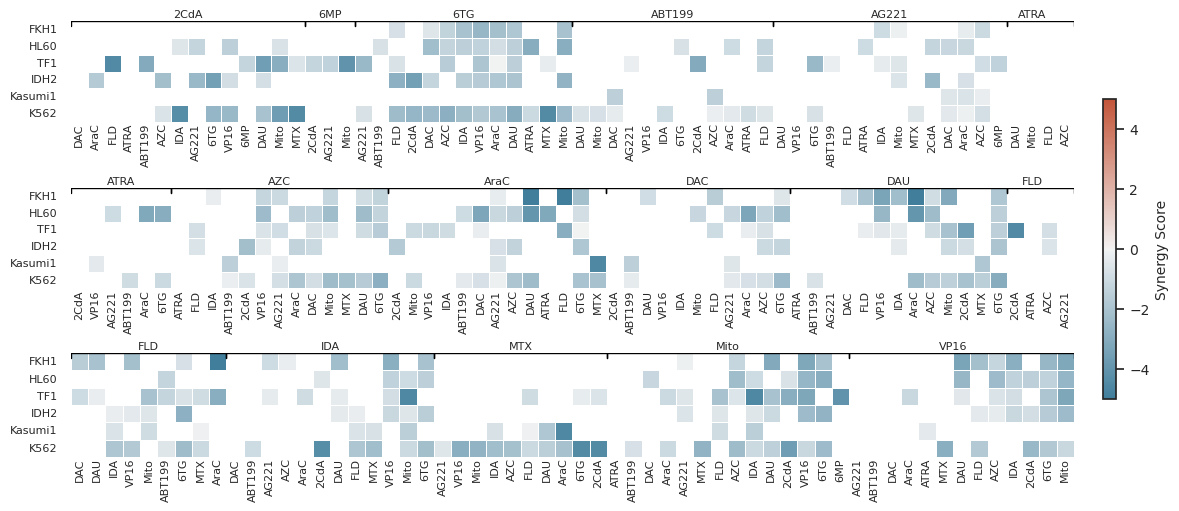

In [70]:
# drug classes sorted
fig, axes = plt.subplots(3,1,figsize=(11,6))
for axi, r in enumerate([(0,60), (60,120), (120,dfp_filt.shape[0])]):
    ax = axes[axi]
    hax = sns.heatmap(df.loc[:,sorted_series.index[r[0]:r[1]]], ax=ax, cmap=cmap, vmax=5, center=0, vmin=-5,
                    square=True, linewidths=.5, 
                    xticklabels=[f'{l[1]}' for l in sorted_series.index[r[0]:r[1]]],
                    yticklabels=df.index,
                    cbar=False, cbar_kws={"shrink": .5, "location":"right"})
    ax.tick_params(labelsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.setp(ax.get_xticklabels(), position=(0, 0.12))

    column_labels = [f'{l[0]}' for l in sorted_series.index[r[0]:r[1]]]
   # Process the column labels to determine the start and end column for each group
    prev_label = column_labels[0]
    start_col = 0
    for i, label in enumerate(column_labels[1:], 1):
        if label != prev_label:
            # If label changes, then put the group label and bracket for the previous group
            end_col = i - 1
            center_col = (start_col + end_col + 1) / 2
            
            ax.annotate(prev_label, 
                        xy=(center_col, 0),
                        xycoords='data',
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='center',
                        fontsize=8)

            bracket_length = 0.3
            line = plt.Line2D([start_col, start_col, end_col+1, end_col+1],
                            [bracket_length, 0, 0, bracket_length],
                            color='black', lw=1)
            ax.add_line(line)
            
            # Start a new group
            start_col = i
            prev_label = label

    # Add label and bracket for the last group
    center_col = (start_col + i) / 2
    ax.annotate(prev_label, 
                xy=(center_col, 0),
                xycoords='data',
                xytext=(0, 5),
                textcoords="offset points",
                ha='center', va='center',
                fontsize=8)

    bracket_length = 0.3
    line = plt.Line2D([start_col, start_col, i+1, i+1],
                    [bracket_length, 0, 0, bracket_length],
                    color='black', lw=1)
    ax.add_line(line)


fig.tight_layout()
cbar_ax = fig.add_axes([1.01, 0.25, 0.012, 0.5])
cbar = fig.colorbar(hax.get_children()[0], cax=cbar_ax)
cbar.set_label(label='Synergy Score', size=10)
cbar.ax.tick_params(labelsize=10)
fig.subplots_adjust(hspace=-0.2)
fig.savefig(PROJECT_PATH / f'figures/Figure 2. dIC50 heatmap by cell line 8-by-8 antagonism only.png',
            dpi=600, bbox_inches='tight')

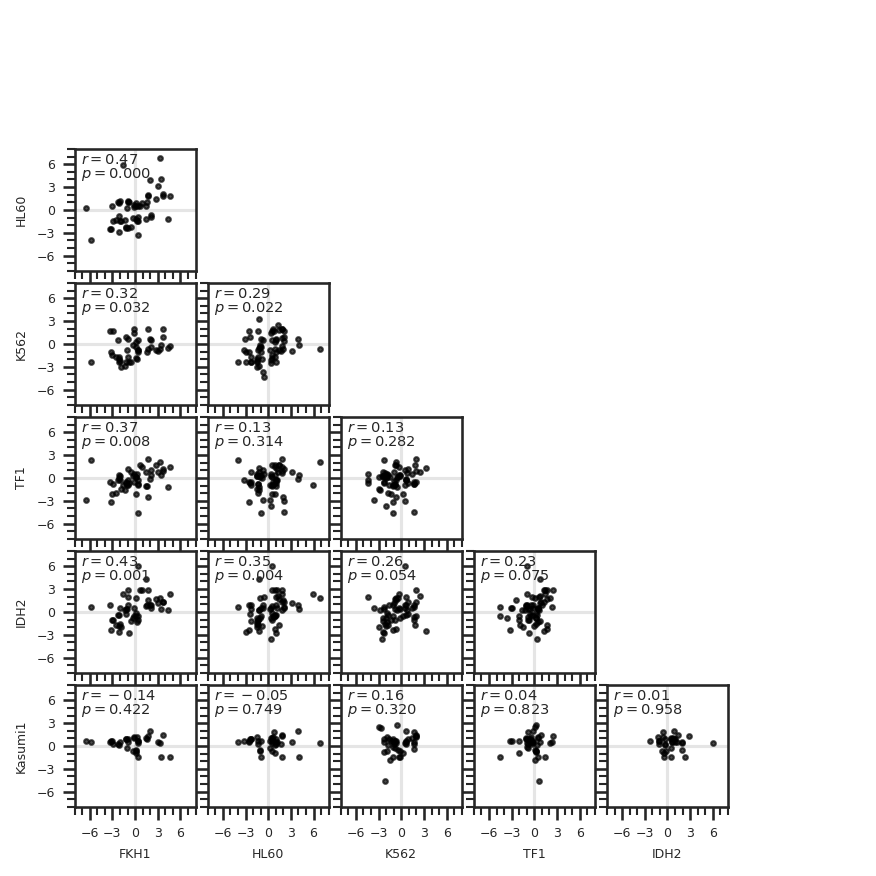

In [10]:
from scipy.stats import pearsonr
def scatter_pairwise_cell_line(cellA, cellB, ax):
    dic_max_comp = pd.merge(left=df_max[df_max['cell_line']==cellA].drop('cell_line',axis=1), right=df_max[df_max['cell_line']==cellB].drop('cell_line',axis=1), on=['drugA', 'drugB'])
    dic_max_comp['drug_pair'] = dic_max_comp['drugA'] + "_" + dic_max_comp['drugB']
    dic_max_comp.drop(['drugA','drugB'],axis=1,inplace=True)
    # show only drug pairs that have greater than 2 fold dIC50
    #dic_max_comp = dic_max_comp[(dic_max_comp['dIC50_x']>=1) | (dic_max_comp['dIC50_y']>=1)]
    ax.plot([-8,8],[0,0],color='black',alpha=0.1,zorder=1)
    ax.plot([0,0],[-8,8],color='black',alpha=0.1,zorder=1)
    ax.scatter(-dic_max_comp['dIC50_y'], -dic_max_comp["dIC50_x"], s=5, color='black',alpha=0.7,zorder=2)
    ax.set_xlim([-8,8])
    ax.set_ylim([-8,8])
    # ax.set_yticks(list(range(9)))
    # ax.set_xticks(list(range(9)))
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(3))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(3))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    ax.tick_params(labelsize=6)
    # get the correlation between all valid drug pair estimations
    dic_max_comp = dic_max_comp.loc[~pd.isna(dic_max_comp['dIC50_x']) & ~pd.isna(dic_max_comp['dIC50_y']),:]
    r, p = pearsonr(dic_max_comp['dIC50_x'],dic_max_comp['dIC50_y'])
    ax.text(-7.2, 6., f'$r={r:.2f}$',fontsize=7, zorder=100)
    ax.text(-7.2, 4.25, f'$p={p:.3f}$',fontsize=7, zorder=100)
    #ax.axis('square')
    return (r, p)

fig, axes = plt.subplots(6,6, figsize=(6,6), dpi=150)
corr = {}
for ploti, cell_line_i in enumerate(dic50_df['cell_line'].unique()):
    for plotj, cell_line_j in enumerate(dic50_df['cell_line'].unique()): 
        ax = axes[ploti, plotj]
        # plot only lower triangle
        if ploti > plotj:
            r, p = scatter_pairwise_cell_line(cell_line_i, cell_line_j, ax)
            corr[(cell_line_i,cell_line_j)] = (r,p)
            corr[(cell_line_j,cell_line_i)] = (r,p)
            if plotj!=0:
                ax.set_yticklabels([])
            else:
                ax.set_ylabel(cell_line_i,fontsize=6)
            if ploti!=5:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(cell_line_j,fontsize=6)
        else:
            ax.set_axis_off()
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)
fig.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/dic50_correlations_btw_cell_lines.png',
            dpi=600, bbox_inches='tight')

In [11]:
order = ['FKH1', 'HL60', 'K562','IDH2','TF1','Kasumi1']
df_corr = pd.DataFrame(corr).T.reset_index().pivot(index='level_0', columns='level_1').loc[order,:]
df_r = df_corr.loc[:,(0,order)].droplevel(0,axis=1)
df_p = df_corr.loc[:,(1,order)]
df_r

level_1,FKH1,HL60,K562,IDH2,TF1,Kasumi1
level_0,,,,,,
FKH1,NaN,0.468979,0.319800,0.433832,0.365162,-0.142276
HL60,0.468979,NaN,0.287754,0.353055,0.126905,-0.054478
K562,0.319800,0.287754,NaN,0.256596,0.133336,0.157175
IDH2,0.433832,0.353055,0.256596,NaN,0.225983,0.009537
TF1,0.365162,0.126905,0.133336,0.225983,NaN,0.036008
Kasumi1,-0.142276,-0.054478,0.157175,0.009537,0.036008,NaN


In [12]:
print(np.ma.mean(np.ma.masked_invalid(df_r.values.flatten())))
print(np.ma.std(np.ma.masked_invalid(df_r.values)))

print(np.ma.mean(np.ma.masked_invalid(df_r),axis=1))
print(np.ma.std(np.ma.masked_invalid(df_r),axis=1))

0.19849127421100257
0.17518202234371205
[0.28909942507689534 0.2364429894926953 0.23093244744249555
 0.25580065078147146 0.1774790103384956 0.0011931221339622447]
[0.22186360291249776 0.18272264552423576 0.07314370372666222
 0.1433102069941694 0.1114431731828124 0.09929241890262244]


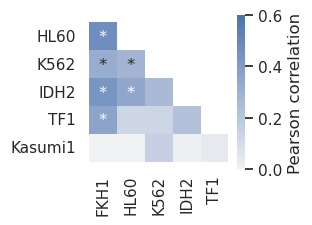

In [13]:
data = df_r.iloc[1:, :-1]
annot_data = df_p.iloc[1:, :-1]
annot = annot_data.lt(0.05).applymap(lambda x: '*' if x else '')

f = plt.figure(figsize=(2.25, 2))

mask = np.triu(np.ones_like(data, dtype=bool), k=1)
ax = sns.heatmap(data, mask=mask, annot=annot,  fmt='',
                 cmap=sns.color_palette("light:b", as_cmap=True), vmin=0, vmax=0.6,
                 cbar_kws={'label': "Pearson correlation"})
ax.set_aspect('equal')
plt.xlabel('')
plt.ylabel('')

f.savefig(PROJECT_PATH / f'figures/Figure 4A. Cell line vs. cell line pearson.png', dpi=600, bbox_inches='tight')

#### Export dIC50_max for each drug pair and cell line

In [10]:
significant_pairs = df_max[df_max['dIC50']<-1].sort_values(by='dIC50',ascending=True)
all_pairs = df_max.sort_values(by='dIC50',ascending=True)

all_pairs.to_csv(PROJECT_PATH / 'dump/sigmoid_synergy_estimations/All synergistic pairs 8x8.csv',index=False)
significant_pairs.to_csv(PROJECT_PATH / 'dump/sigmoid_synergy_estimations/Significant synergistic pairs 8x8.csv',index=False)